# Langevin Dynamics of a particle in a harmonic well potential

- When the system has viscosity and temperature... could you predict, before performing any experiment, what is the probability that the particle visits a given point in space with coordinates (x,y,z). That is, can you calculate analytically what is the probability density distribution $P(x,y,z)$?

- With the previous point solved... Do you think that observing how the system behaves in a single dimension (X, for example) can help us to understand the three-dimensional system? Is what we can observe in the X independent of what happens in the Y-axis or in the Z-axis? For example, the probability that the particle is in some coordinates or has some velocities, does it factor in its three dimensions?
$P(x,y,z)=P(x)*P(y)*P(z)$? $P(v_x, v_y, v_z)=P(v_x)*P(v_y)*P(v_z)$

- Can you run a simulation and plot the observed $P(x)$ probability density along the trajectory along with the theoretical probability density? How does it change with temperature? And with viscosity? Do you need a lot or a little simulation time to observe a good fit to the theoretical distribution?

- What is the average kinetic energy of the system, can you calculate it theoretically?

- What integration step have you chosen to perform your molecular dynamics simulation? What happens when the integration step is larger than one tenth of the harmonic oscillation period $T$ of the well... for example $T/2$? What happens when the integration step is smaller than one tenth of the period $T$... for example $T/20$?




In [1]:
%matplotlib inline

import openmm
import openmm.app as app
import openmm.unit as unit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

## Simulation with harmonic potential

In [2]:
CARBON_MASS = 12.010 * unit.amu
OXYGEN_MASS = 15.999 * unit.amu

In [3]:
def create_topology() -> openmm.app.Topology:
    """ Returns the topology of a CO molecule
    """
    topology = app.Topology()
    chain = topology.addChain()
    residue = topology.addResidue("CO", chain)

    carbon = app.Element.getBySymbol("C")
    oxygen = app.Element.getBySymbol("O")

    carbon = topology.addAtom("C", carbon, residue)
    oxygen = topology.addAtom("O", oxygen, residue)

    topology.addBond(carbon, oxygen)

    assert topology.getNumAtoms() == 2
    assert topology.getNumBonds() == 1

    return topology

In [4]:
def create_system() -> openmm.System:
    """ Create the system with an argon atom.
    """
    system = openmm.System()
    reduced_mass = (CARBON_MASS * OXYGEN_MASS) / (CARBON_MASS + OXYGEN_MASS)
    system.addParticle(reduced_mass)

    K = 10.0 * unit.kilocalorie_per_mole/unit.nanometers**2

    # Add the harmonic potential
    force = openmm.CustomExternalForce('(K/2.0) * (x^2 + y^2 + z^2)')
    force.addGlobalParameter('K', K * unit.kilocalories_per_mole/unit.angstrom**2)
    force.addParticle(0)

    system.addForce(force)
    return system

In [5]:
def create_simulation(
        system: openmm.System,
        topology: openmm.app.Topology,
        temperature: float,
        friction: float,
        step: openmm.unit.Quantity,
        platform_name: str="CPU",
        initial_vel=0
) -> openmm.app.Simulation:
    """ Returns a simulation object.
    """
    temperature = temperature*unit.kelvin
    friction_coeff = friction/unit.picosecond

    integrator = openmm.LangevinIntegrator(
        temperature, friction_coeff, step
    )

    # Initial position and velocities
    pos = np.zeros((1, 3), np.float32) * unit.angstroms
    vel = np.ones((1, 3), np.float32) * initial_vel * unit.angstroms/unit.picoseconds

    platform = openmm.Platform.getPlatformByName(platform_name)

    simulation = app.Simulation(topology, system, integrator, platform)

    simulation.context.setPositions(pos)
    simulation.context.setVelocities(vel)

    return simulation

In [6]:
def prepare_simulation(temperature: float, friction: float,
                       step: openmm.unit, initial_vel: float=0):
    """ Returns a simulation object ready to run a simulation."""
    topology = create_topology()
    system = create_system()
    return create_simulation(
        system, topology, temperature, friction, step,
        initial_vel=initial_vel
    )

In [7]:
def run_sim(simulation: openmm.app.Simulation,
            step: openmm.unit.Quantity,
            sim_time: openmm.unit.Quantity,
            save_time: openmm.unit.Quantity):
    """ Run the simulation while saving the positions, times and velocities
        to numpy arrays

        Returns
        -------
        tuple[np.ndarray]
            An array for time, position and velocity.
    """
    n_steps_per_period = int(save_time/step)
    n_periods = int(sim_time/save_time)

    time = np.zeros([n_periods], np.float32) * unit.picoseconds
    position = np.zeros([n_periods, 1, 3], np.float32) * unit.angstroms
    velocity = np.zeros([n_periods, 1, 3], np.float32) * unit.angstroms/unit.picosecond
    pot_energy = np.zeros([n_periods], np.float32) * unit.kilocalorie_per_mole
    kin_energy = np.zeros([n_periods], np.float32) * unit.kilocalorie_per_mole

    for ii in tqdm(range(n_periods)):
        simulation.step(n_steps_per_period)
        state = simulation.context.getState(
            getPositions=True, getVelocities=True,
            getEnergy=True
        )

        time[ii] = state.getTime()
        position[ii] = state.getPositions()
        velocity[ii] = state.getVelocities()
        pot_energy[ii] = state.getPotentialEnergy()
        kin_energy[ii] = state.getKineticEnergy()

    return time, position, velocity, pot_energy, kin_energy


In [8]:
def plot_coordinates(time_array, positions):
    """ Plot the x, y and z coordinate against time. Each coordinate in
        a different plot.
    """

    plt.rcParams['figure.figsize'] = 18, 4

    for ii, axis_label in zip(range(3),['X','Y','Z']):
        plt.plot(time_array, positions[:,0,ii])
        plt.ylabel('{} ({})'.format(axis_label, positions.unit))
        plt.xlabel('time ({})'.format(time_array.unit))
        plt.show()

In [9]:
def plot_2d(positions):
    """ Plot the X coordinate against the Y coordinate.
    """
    plt.rcParams['figure.figsize'] = 5, 5

    plt.plot(positions[:,0,0], positions[:,0,1])
    plt.xlabel('X ({})'.format(positions.unit))
    plt.ylabel('Y ({})'.format(positions.unit))
    plt.show()

In [10]:
def plot_energy(time_array, kinetic_energy, potential_energy):
    """ Plot the kinetic and potential energy of the system.
    """
    plt.rcParams['figure.figsize'] = 18, 4

    plt.plot(time_array, potential_energy)
    plt.ylabel('Potential Energy ({})'.format(potential_energy.unit))
    plt.xlabel('time ({})'.format(time_array.unit))
    plt.show()

    plt.plot(time_array, kinetic_energy)
    plt.ylabel('Kinetic Energy ({})'.format(kinetic_energy.unit))
    plt.xlabel('time ({})'.format(time_array.unit))
    plt.show()


In [34]:
def simulate_and_plot(
        temperature: float, friction: float, step: float=0.1,
        initial_vel: float=0, sim_time=0.5, save_time=1.0
):
    """ Run a simulation and plot it.
    """
    step = step * unit.picosecond
    simulation = prepare_simulation(
        temperature, friction, step, initial_vel
    )
    time, positions, velocities, pot, kin = run_sim(
        simulation,
        step,
        sim_time=sim_time * unit.nanosecond,
        save_time=save_time * unit.picoseconds
    )

    plot_coordinates(time, positions)
    plot_2d(positions)
    plot_energy(time, kin, pot)

100%|██████████| 500/500 [00:03<00:00, 148.52it/s]


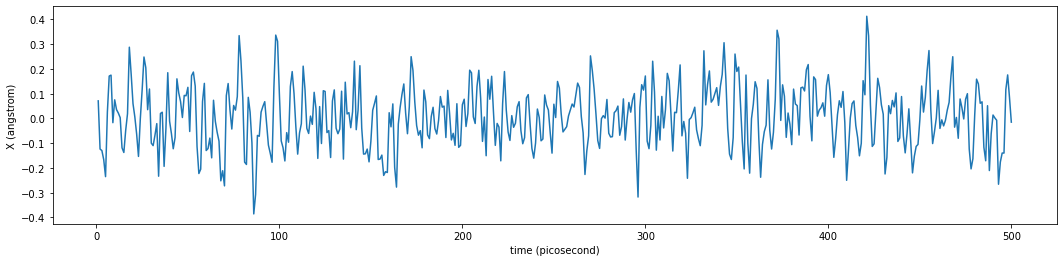

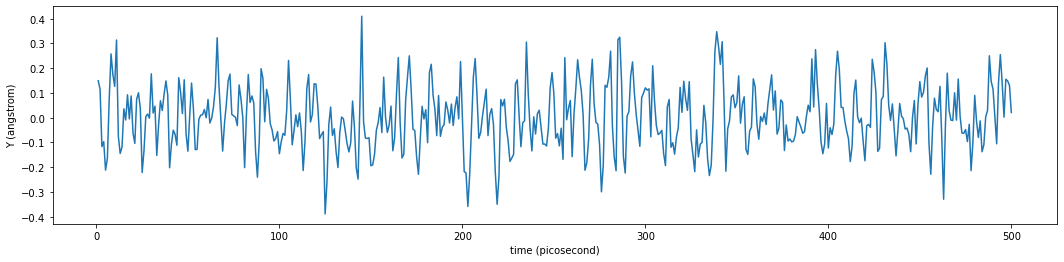

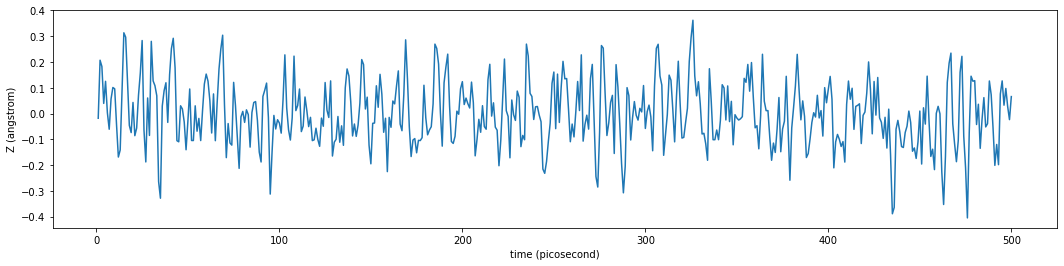

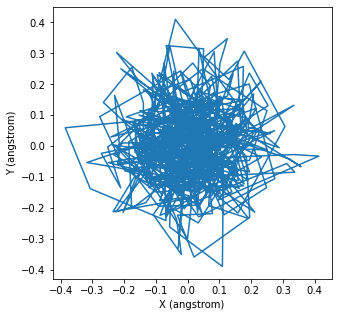

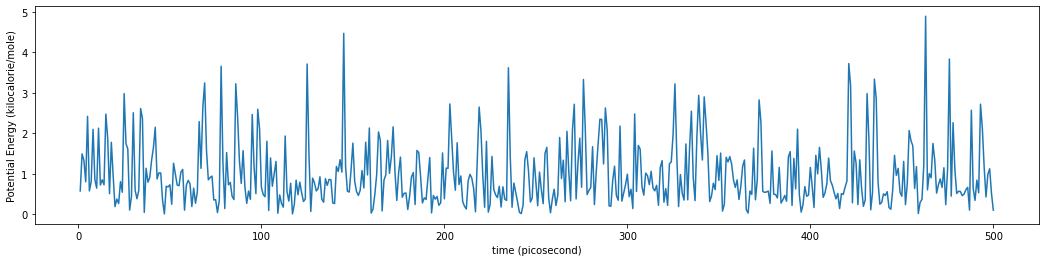

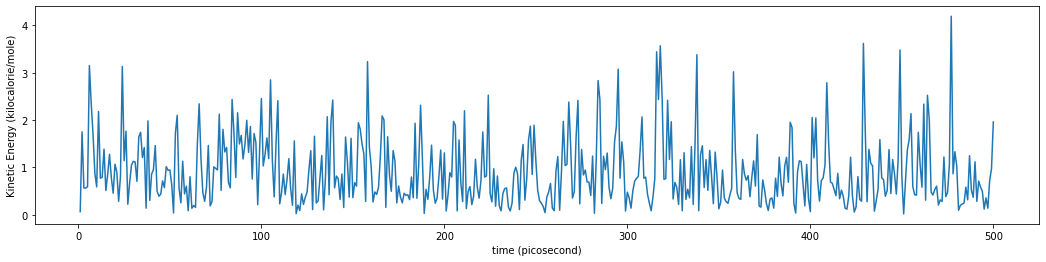

In [36]:
simulate_and_plot(
    temperature=300, friction=1.0, step=0.01,
    initial_vel=0, sim_time=.5, save_time=1.0
)

## Simulating at different conditions

### Zero temperature and viscosity

100%|██████████| 200/200 [00:00<00:00, 288.28it/s]


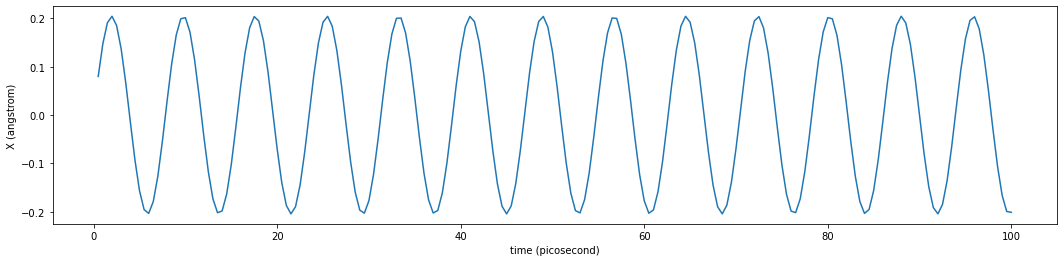

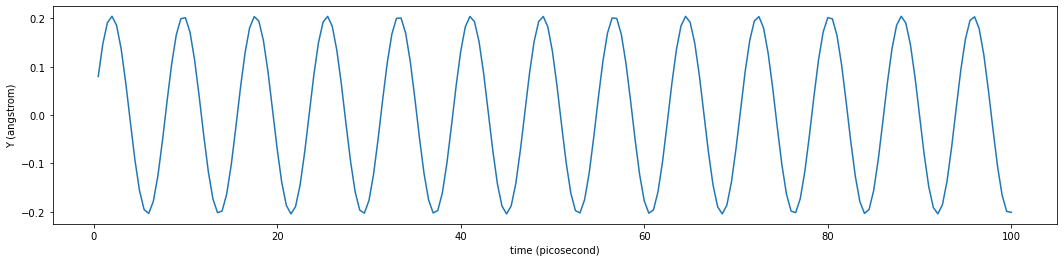

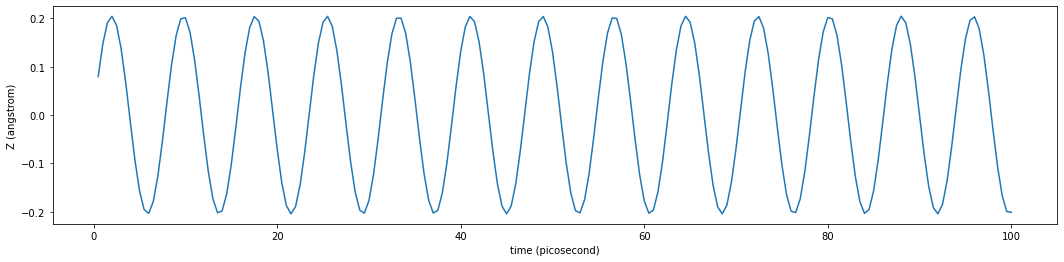

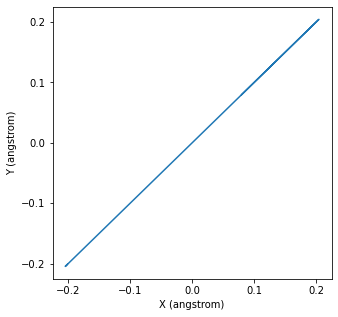

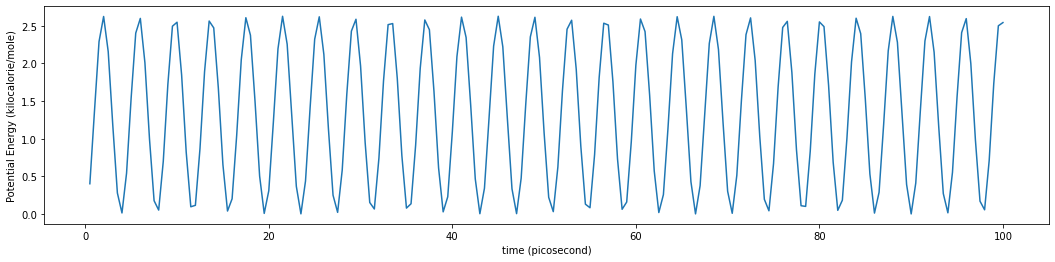

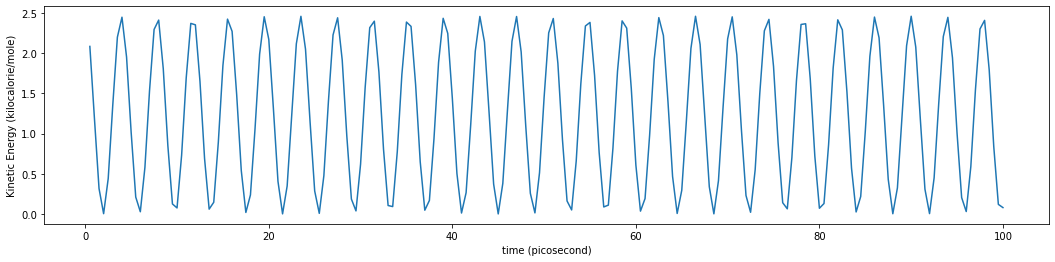

In [37]:
simulate_and_plot(
    temperature=0, friction=0, step=0.01,
    initial_vel=10, sim_time=0.1, save_time=0.5)

### Zero temperature

100%|██████████| 200/200 [00:00<00:00, 288.03it/s]


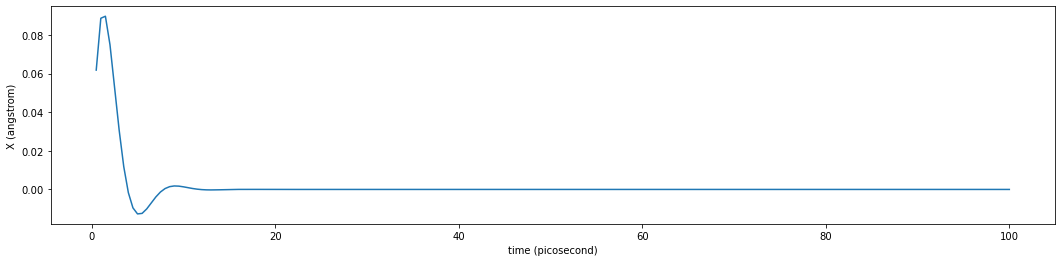

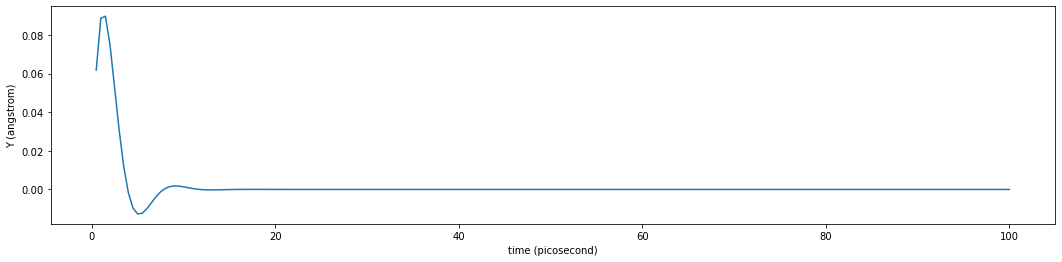

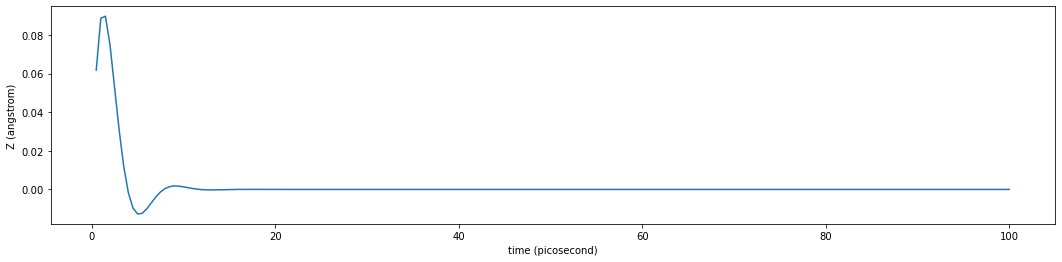

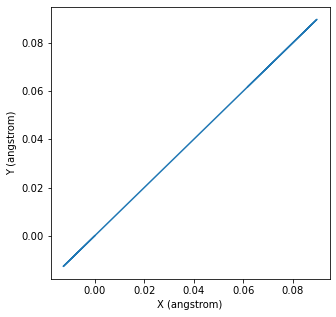

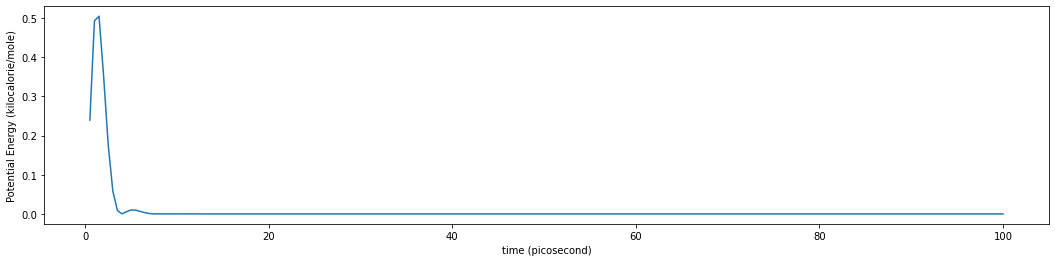

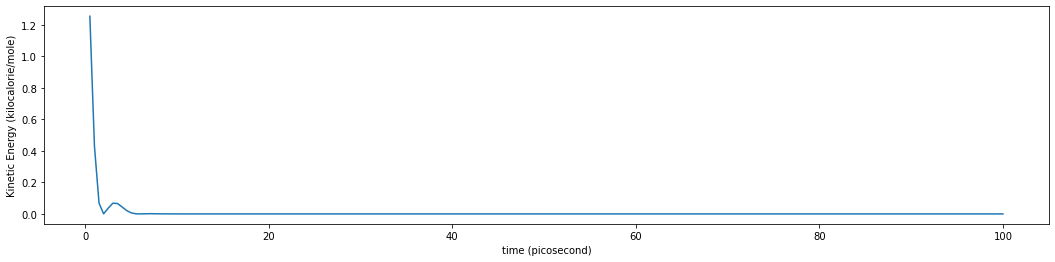

In [38]:
simulate_and_plot(
    temperature=0, friction=1.0, step=0.01,
    initial_vel=10, sim_time=0.1, save_time=0.5)

## Zero viscosity

100%|██████████| 200/200 [00:00<00:00, 258.11it/s]


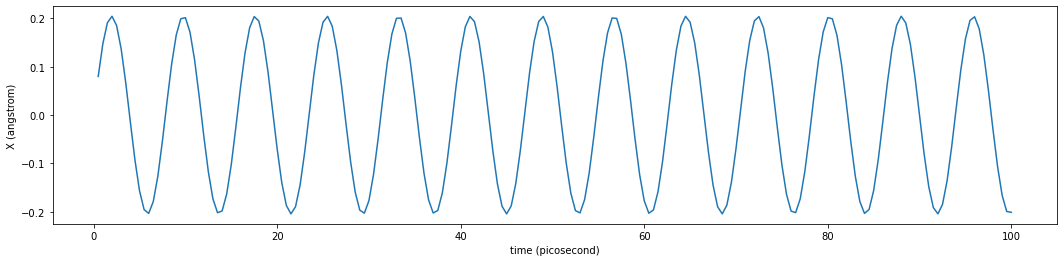

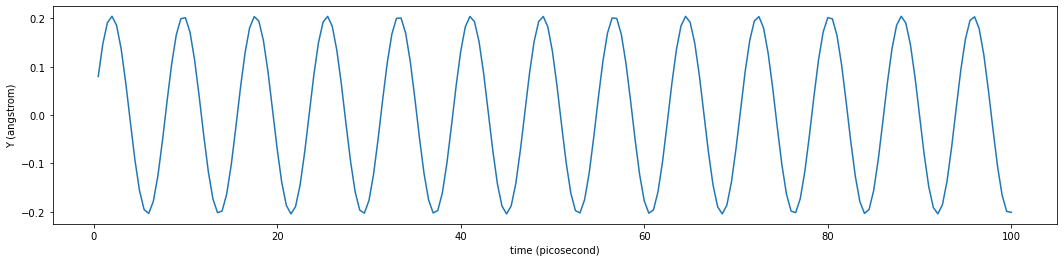

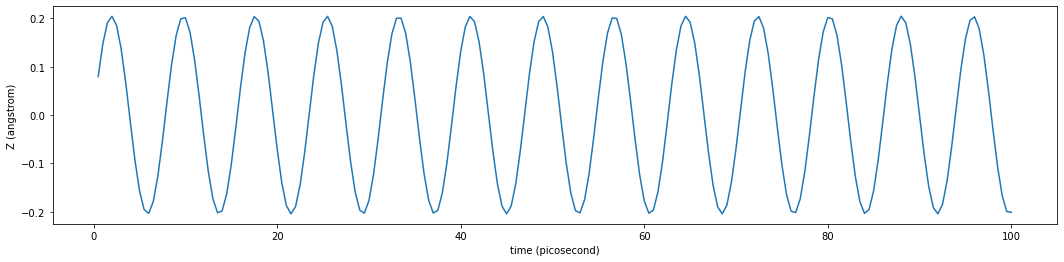

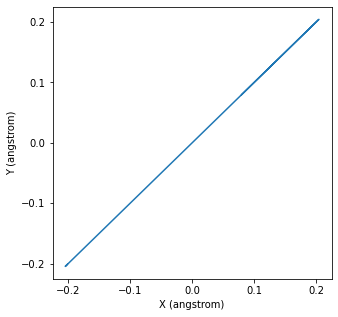

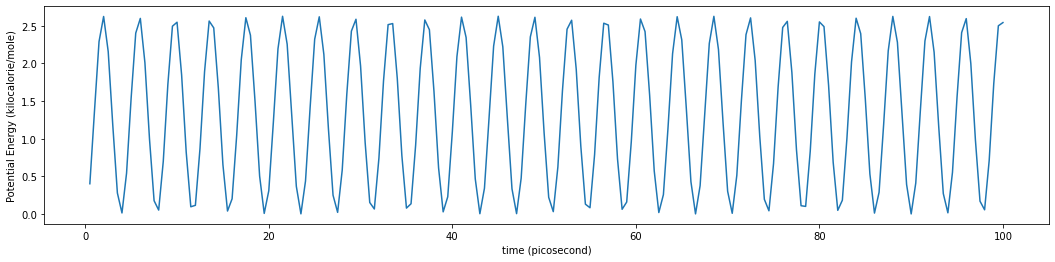

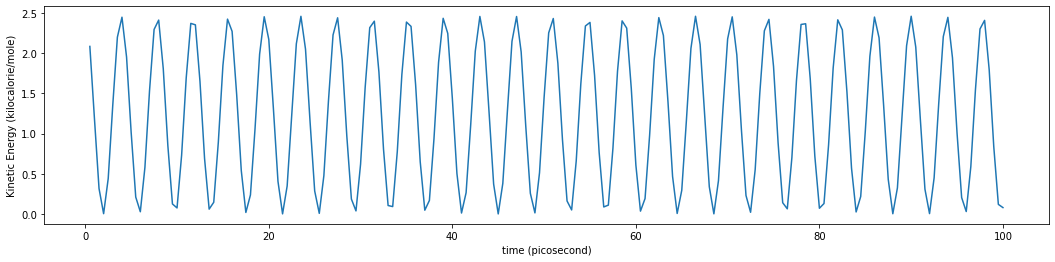

In [39]:
simulate_and_plot(
    temperature=300, friction=0.0, step=0.01,
    initial_vel=10, sim_time=0.1, save_time=0.5
)

## Probability density

The theoretical probability density is
$$ P(X) = \sqrt{\frac{K}{2\pi k_BT}}\exp{(-\frac{\beta}{2}Kx^2)} $$

In [56]:
BOLTZMANN = openmm.unit.constants.BOLTZMANN_CONSTANT_kB

def probability_density(temperature: openmm.unit.Quantity,
                        positions: openmm.unit.Quantity) -> np.ndarray:
    """ Calculate the theoretical probability density in one
        dimension.
    """
    beta = BOLTZMANN * temperature
    K = 0.001 * unit.angstrom/unit.picosecond**2
    constant = beta * K / (2 * np.pi)
    constant = np.sqrt(constant.value_in_unit(constant.unit))
    return  constant * np.exp((-beta / 2) * np.square(positions))



def plot_prob_density() -> None:
    """ Plot the theoretical probability density.
    """
    positions = np.linspace(-0.5, 0.5) * unit.angstroms
    prob = probability_density(temperature=300*unit.kelvin,
                               positions=positions
                               )

    plt.rcParams['figure.figsize'] = 18, 4

    plt.plot(positions, prob)
    plt.ylabel("P(X)")
    plt.xlabel('X ({})'.format(positions.unit))
    plt.show()

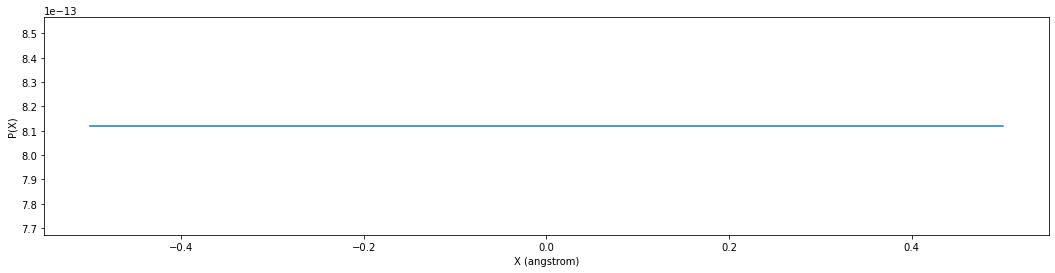

In [57]:
plot_prob_density()

In [54]:
def plot_experimental_probability_density():

    step = 0.01 * unit.picosecond
    simulation = prepare_simulation(
        temperature=300,
        friction=0.1,
        step=step,
        initial_vel=0
    )
    _, positions, _, _, _ = run_sim(
        simulation,
        step,
        sim_time=100.0 * unit.nanosecond,
        save_time=1.0 * unit.picoseconds
    )
    positions = np.squeeze(positions)

    plt.hist(positions[:, 0], bins="auto")
    plt.ylabel("P(X)")
    plt.xlabel('X (angstroms)')
    plt.show()

100%|██████████| 100000/100000 [12:54<00:00, 129.13it/s]


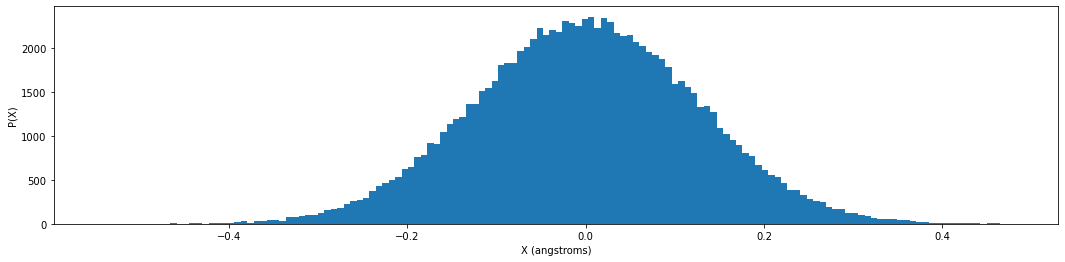

In [55]:
plot_experimental_probability_density()